In [5]:
import json
import numpy as np
import pandas as pd
import sys 
sys.path.append("..")
from src.utils_methods import encode, get_var_metadata, post_process, transform_df_to_json, generate_plots

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data_folder = "../results/"
with open(data_folder + "real/real_structures.json") as f:
    real_orig = json.load(f)

DATA_ARRAY = [real_orig]
DATA_NAMES = ["real"]
to_plot = DATA_NAMES

brace_dict = {    
    "NONE": 0,
    "H": 1,
    "Z": 2,
    "IZ": 3,
    "ZH": 4,
    "IZH": 5,
    "K": 6,
    "X": 7,
    "XH": 8,
    "nan": 9,
}

brace_dict_inv = dict(zip(brace_dict.values(), brace_dict.keys()))

N_BRACES = len(brace_dict)


max_layers = max(d.get('n_layers', 0) for sublist in DATA_ARRAY for d in sublist)
transformed_columns = ["legs", "total_height", "radius_bottom", "radius_top", "n_layers"]
brace_cols = ["brace" + str(i) for i in range(max_layers-1)] 
layer_cols = ["layer_height" + str(i) for i in range(max_layers-2)]
transformed_columns += brace_cols
transformed_columns += layer_cols

dataframes = []
for dataset, name in zip(DATA_ARRAY, DATA_NAMES):
    encoding = [encode(d, max_layers, brace_dict, N_BRACES, one_hot=False, native=True, normalize_layer_heights=True) for d in dataset]
    df_ = pd.DataFrame(encoding, columns=transformed_columns)
    df_["label"] = [name]*len(df_)
    dataframes.append(df_.copy())
    
train_original = pd.concat(dataframes, axis=0, ignore_index=True)

nominal_features = brace_cols
ordinal_features = ["n_layers", "legs"]
BERNOULLI = ["legs"]

discrete_features = nominal_features + ordinal_features


continuous_features = list(set(transformed_columns) - set(nominal_features) - set(ordinal_features))

train_original[ordinal_features] = train_original[ordinal_features].astype("int")
train_original[continuous_features] = train_original[continuous_features].astype("float")
train = train_original.drop("label", axis=1)
train = train.infer_objects()


In [7]:
var_distrib, var_transform_only, le_dict, brace_cols, unique_braces = get_var_metadata(train, train_original, brace_cols, BERNOULLI)

In [8]:
var_distrib

array(['bernoulli', 'continuous', 'continuous', 'continuous', 'ordinal',
       'bernoulli', 'bernoulli', 'categorical', 'categorical',
       'bernoulli', 'continuous', 'continuous', 'continuous',
       'continuous'], dtype='<U11')

In [9]:
def generate_database_plots(train_original, var_distrib, le_dict, brace_cols, unique_braces, res_folder):

    x_lim = []
    y_lim = []

    df_data = pd.DataFrame()
        
        
    continuous_position = 0
    for col_idx, colname in enumerate(train_original.columns[:-1]):
        df_data[colname] = train_original[colname]
        df_data["Data"] = train_original["label"]
        
        df_scatter = df_data
        
        if var_distrib[col_idx] in ['categorical', 'bernoulli', "ordinal"]: 

            unique_labels = le_dict[colname].classes_
            le_name_mapping = dict(zip(le_dict[colname].classes_, le_dict[colname].transform(le_dict[colname].classes_)))
            if colname in brace_cols:
                unique_vals = unique_braces
            else:  
                unique_vals = df_scatter[colname].to_numpy().flatten()
                unique_vals = list(set(unique_vals))
                unique_vals.sort()

            fig, ax = plt.subplots(figsize=(6, 6), nrows=1, ncols=1)
            distribution_ax = ax

            # Count the occurrences of each number of legs per cluster
            items_per_cluster = df_scatter.groupby(['Data', colname]).size().unstack().fillna(0)
            
            rev_unique_vals = unique_vals
            change_cols_list = [col for col in rev_unique_vals if col in items_per_cluster.columns]
            
            # Reorder the columns based on the sorted labels
            items_per_cluster = items_per_cluster[change_cols_list]
            df = df_scatter.astype(str)
            # Calculate percentages
            # Calculate percentages per 'Data' category
            
            order = [str(x) for x in unique_vals]
            g = sns.histplot(df_scatter.astype(str), x='Data', hue=colname, hue_order=order, ax=distribution_ax, palette=sns.color_palette("tab10"))
    #         g.legend(handles, labels)
    #         ax.margins(x=0.5)
            distribution_ax.xaxis.set_tick_params(rotation=0)
            if res_folder is not None:
                plt.savefig(res_folder + "figures/" + "synthetic_" + colname + ".png", 
                    bbox_inches='tight', 
                    transparent=True,
                    pad_inches=0, dpi=200)
            plt.show()
            
        else:
            fig, ax = plt.subplots(figsize=(6, 6), nrows=1, ncols=1)
            distribution_ax = ax
            continuous_position += 1
            if len(x_lim)>0:
                ax[1].set_xlim(x_lim[0], x_lim[1])
                ax[1].set_ylim(y_lim[0], y_lim[1])
                
            sns.kdeplot(data=df_scatter, x=colname, hue="Data", ax=distribution_ax, bw_adjust=0.3)
            if res_folder is not None:
                plt.savefig(res_folder + "figures/" + "synthetic_" + colname + ".png", 
                bbox_inches='tight', 
                transparent=True,
                pad_inches=0, dpi=200)
            plt.show()

In [10]:
def plot_all(df, brace_cols, layer_cols, var_distrib):
    columns_to_plot = df.columns.tolist()
    # Remove grouped columns to avoid redundancy
    columns_to_plot = [col for col in columns_to_plot if col not in brace_cols + layer_cols]

    # Calculate the number of rows and columns for the subplots
    num_rows = len(columns_to_plot)
    num_cols = 2  # You can adjust the number of columns based on your preference

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 4 * num_rows))

    # Plot continuous variables
    for i, col in enumerate(columns_to_plot):
        row_idx = i // num_cols
        col_idx = i % num_cols
        sns.histplot(df[col], ax=axes[row_idx, col_idx], kde=True)
        axes[row_idx, col_idx].set_title(f'{col} - Statistics')

    # Plot discrete variables
    for j, col_group in enumerate([brace_cols, layer_cols]):
        row_idx = (num_rows + j) // num_cols
        col_idx = (num_rows + j) % num_cols
        df[col_group].stack().value_counts().plot(kind='bar', ax=axes[row_idx, col_idx])
        axes[row_idx, col_idx].set_title(f'{", ".join(col_group)} - Counts')

    plt.tight_layout()
    plt.show()

In [11]:
train_original.drop("label", axis=1)
train_original = train_original.replace("nan", None)
train_original

,legs,total_height,radius_bottom,radius_top,n_layers,brace0,brace1,brace2,brace3,brace4,layer_height0,layer_height1,layer_height2,layer_height3,label
0,4,22.0,16.968,15.554,2,X,None,None,None,None,1.000000,1.000000,1.000000,1.000000,real
1,3,77.0,21.362,11.761,3,X,X,None,None,None,0.545455,1.000000,1.000000,1.000000,real
2,4,32.9,20.704,6.640,3,X,X,None,None,None,0.545593,1.000000,1.000000,1.000000,real
3,3,50.0,16.166,8.706,3,X,X,None,None,None,0.482000,1.000000,1.000000,1.000000,real
4,3,51.0,19.029,9.336,3,X,X,None,None,None,0.549020,1.000000,1.000000,1.000000,real
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4,44.5,19.796,7.777,5,X,X,X,X,None,0.325843,0.595506,0.820225,1.000000,real
96,4,43.5,18.382,7.777,5,X,X,X,X,None,0.321839,0.593103,0.816092,1.000000,real
97,4,50.3,18.382,7.777,5,X,X,X,X,None,0.310139,0.574553,0.805169,1.000000,real
98,4,52.0,18.382,7.777,5,X,X,X,X,None,0.213462,0.446154,0.734615,1.000000,real


In [12]:
pretty_names = {"total_height":r"Total height ($H$)", "radius_bottom":r"Base radius ($R_b$)" ,
                "radius_top": r"Top radius ($R_t$)", "n_layers": r"Number of layers ($L$)",
                "brace": r"Brace connection types ($C$)", "layer_height": r"Layer heights ($E$)",
                "legs": r"Number of Legs ($N$)"}

constr = {"total_height":[17,95], "radius_bottom":[9,29] ,
         "radius_top": [2,18], "layer_height": [0,1]}

contin = ["total_height", "radius_bottom", "radius_top"]

discr = ["n_layers", "legs"]


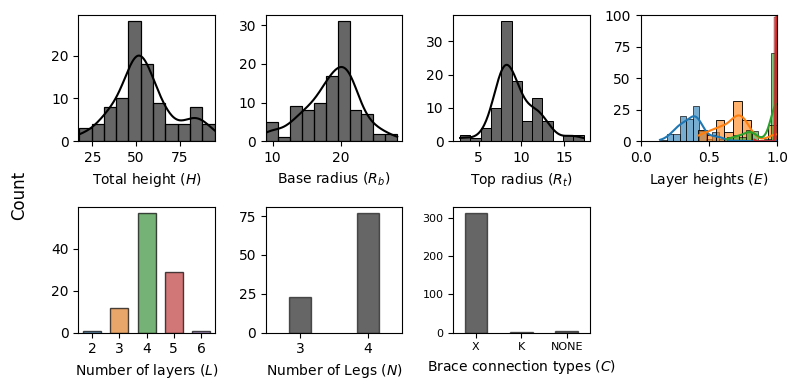

In [13]:
df = train_original.reset_index()
ALPHA = 0.6
ALPHA_count = 0.7
num_rows = 2
num_cols = 4

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8, 2 * num_rows))

num_plots = 0
for cont in contin:
    row_idx = num_plots // num_cols
    col_idx = num_plots % num_cols
    x_lim = constr[cont]
    axis = axes[row_idx][col_idx]
    axis.set_xlim(x_lim[0], x_lim[1])
            
    sns.histplot(data=df, x=cont, ax=axis, color="black", kde=True, alpha=ALPHA)

    axis.set_xlabel(pretty_names[cont])
    axis.set_ylabel("")
    num_plots += 1
    # yticks = axis.get_yticks()
    # axis.set_yticklabels([f"{tick:.0f}" for tick in yticks], fontsize=8)


row_idx = num_plots // num_cols
col_idx = num_plots % num_cols
x_lim = constr["layer_height"]
axis = axes[row_idx][col_idx]


for layer_col in layer_cols:
    row_idx = num_plots // num_cols
    col_idx = num_plots % num_cols
    x_lim = constr["layer_height"]
    axis = axes[row_idx][col_idx]
    axis.set_xlim(x_lim[0], x_lim[1])

    sns.histplot(data=df, x=layer_col, ax=axis, kde=True, alpha=ALPHA, edgecolor='black')
    axis.set_ylim(0, 100)
    axis.set_xlabel(pretty_names["layer_height"])
    axis.set_ylabel("")
    # yticks = axis.get_yticks()
    # axis.set_yticklabels([f"{tick:.0f}" for tick in yticks], fontsize=8)

num_plots += 1

for disc in discr:
    row_idx = num_plots // num_cols
    col_idx = num_plots % num_cols
    axis = axes[row_idx][col_idx]
    if disc=="n_layers":
        sns.countplot(data=df, x=disc, ax=axis, **{"alpha":ALPHA_count, "edgecolor":'black', "linewidth":1, "width":0.66})
    else:
        sns.countplot(data=df, x=disc, ax=axis, color="black", **{"alpha":ALPHA, "edgecolor":'black', "linewidth":1, "width":0.33})


    axis.set_xlabel(pretty_names[disc])
    axis.set_ylabel("")
    num_plots += 1
    # yticks = axis.get_yticks()
    # axis.set_yticklabels([f"{tick:.1f}" for tick in yticks], fontsize=8)


df_long = df.melt(value_vars=brace_cols)
row_idx = num_plots // num_cols
col_idx = num_plots % num_cols
axis = axes[row_idx][col_idx]
sns.countplot(data=df_long, x='value', ax=axis, color="black", **{"alpha":ALPHA, "edgecolor":'black', "width":0.5})


axis.set_xlabel(pretty_names["brace"])
axis.set_ylabel("")
# yticks = axis.get_yticks()
# axis.set_yticklabels([f"{tick:.0f}" for tick in yticks], fontsize=8)

# axes[0, 0].set_ylabel("Density")
# axes[1, 0].set_ylabel("Count")

fig.supylabel('Count', y=0.5, ha='center', va='center', rotation='vertical')

fig.delaxes(axes[-1, -1])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()  # Add this line to adjust subplot layout
plt.savefig("dataset.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


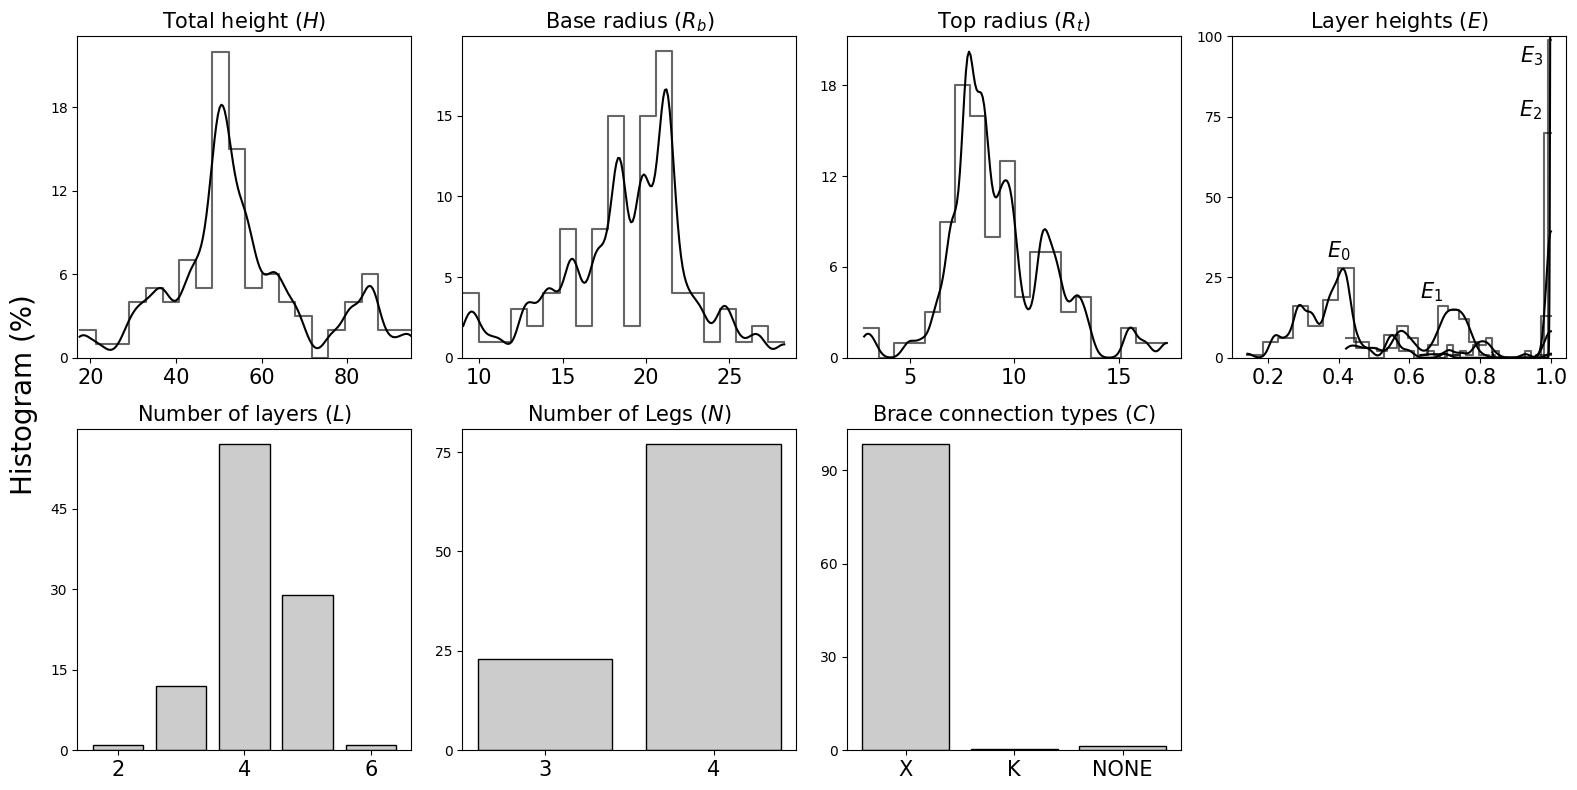

In [14]:
df_concatenated = train_original.reset_index()

df_concatenated.reset_index(drop=True, inplace=True)

arguments = [{"hatch":""}, {"color":"blue", "line_kws":{"linestyle":"--"}, "hatch":'/'},
             {"color":"green", "line_kws":{"linestyle":"-."}, "hatch":'o'},
             {"color":"yellow", "line_kws":{"linestyle":"-"}, "hatch":'-'}]
from matplotlib.ticker import MaxNLocator


df_concatenated["legs"] = df_concatenated["legs"].astype(int)

ALPHA = 0.6
ALPHA_synth = 0.2
ALPHA_count = 0.7
num_rows = 2
num_cols = 4
title_font = 15
tick_size=15

num_rows = 2
num_cols = 4

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 4 * num_rows))


num_plots = 0
for cont in contin:
    row_idx = num_plots // num_cols
    col_idx = num_plots % num_cols
    x_lim = constr[cont]
    axis = axes[row_idx][col_idx]
    axis.set_xlim(x_lim[0], x_lim[1])
            
    sns.histplot(data=df_concatenated, x=cont, ax=axis, color="black", kde=True, alpha=ALPHA, stat="percent", kde_kws={"bw_adjust":0.3}, bins=20, element="step", fill=False)
    
    # for i, df_ in enumerate(dataframes):
    #     if not i:
    #         continue
    #     sns.histplot(data=df_, x=cont, ax=axis, kde=True, alpha=ALPHA_synth, stat="percent", kde_kws={"bw_adjust":0.3}, bins=20, element="step", **arguments[i])

    axis.set_xlabel("")
    axis.set_ylabel("")
    axis.tick_params(axis='x', labelsize=tick_size)
    axis.set_title(pretty_names[cont], fontsize=title_font)

    num_plots += 1
    axis.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))

    # yticks = axis.get_yticks()
    # axis.set_yticklabels([f"{tick:.0f}" for tick in yticks], fontsize=8)


row_idx = num_plots // num_cols
col_idx = num_plots % num_cols
x_lim = constr["layer_height"]
axis = axes[row_idx][col_idx]


for i, layer_col in enumerate(layer_cols):
    row_idx = num_plots // num_cols
    col_idx = num_plots % num_cols
    x_lim = constr["layer_height"]
    axis = axes[row_idx][col_idx]
    # axis.set_xlim(x_lim[0], x_lim[1])

    sns.histplot(data=df_concatenated, x=layer_col, ax=axis, color="black", kde=True, alpha=ALPHA, stat="percent", kde_kws={"bw_adjust":0.3}, bins=20, element="step", fill=False)
    axis.set_ylim(0, 100)
    axis.set_xlabel("")
    axis.set_ylabel("")
    axis.tick_params(axis='x', labelsize=tick_size)
    axis.set_title(pretty_names["layer_height"], fontsize=title_font)
    # Get the histogram data
    hist_data, bin_edges, _ = axis.hist(df_concatenated[layer_col], bins=20, alpha=ALPHA, fill=False, visible=False)

    # Find the index of the maximum bin
    max_bin_index = hist_data.argmax()

    # Get the x and y positions of the maximum point
    x_m = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1]) / 2
    y_m = hist_data[max_bin_index]

    dx = -0.05
    dy = -1*dx
    axis.annotate(r"$E_{}$".format(i), (x_m+x_m*dx, min(90, y_m+y_m*dy)), ha='center', va='bottom', size=tick_size)
    axis.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))




    # yticks = axis.get_yticks()
    # axis.set_yticklabels([f"{tick:.0f}" for tick in yticks], fontsize=8)

num_plots += 1
for disc in discr:
    row_idx = num_plots // num_cols
    col_idx = num_plots % num_cols
    axis = axes[row_idx][col_idx]
    if disc=="n_layers":

        # df1 = df_concatenated.groupby(disc)["label"].value_counts(normalize=True)
        # df1 = df1.mul(100)
        # df1 = df1.rename('percent').reset_index()
        # g = sns.catplot(x=disc,y='percent,kind='bar',data=df1, ax=axis)
        # g.ax.set_ylim(0,100)
        sns.histplot(data=df_concatenated, x=disc, ax=axis, discrete=True, multiple="dodge", stat="percent", common_norm=False, shrink=.8)
        colors = ["C{}".format(i) for i in range(len(df_concatenated[disc].unique()))]
        # for i, bar_group in enumerate(reversed(axis.containers)):
        #     for bar, color in zip(bar_group, colors):
        #         bar.set_facecolor(color)
        #         bar.set_alpha(ALPHA_count) 
        for i, bar_group in enumerate(reversed(axis.containers)):
            for bar in bar_group:
                bar.set_edgecolor("black")
                bar.set_facecolor((0,0,0,0.2))

    else:
        # sns.countplot(data=df, x=disc, ax=axis, color="black", **{"alpha":ALPHA, "edgecolor":'black', "linewidth":1, "width":0.33}, fill=False)
        # sns.countplot(data=df_dgmm, x=disc, ax=axis, color="black", **{"alpha":ALPHA, "edgecolor":'black', "linewidth":1, "width":0.33})
        # sns.countplot(data=df_concatenated, x=disc, ax=axis, **{"alpha":ALPHA_count, "edgecolor":'black', "linewidth":1, "width":0.66})
        sns.histplot(data=df_concatenated, x=disc, ax=axis, discrete=True, multiple="dodge", stat="percent", common_norm=False, shrink=.8)
        for i, bar_group in enumerate(reversed(axis.containers)):
            for bar in bar_group:
                bar.set_edgecolor("black")
                bar.set_facecolor((0,0,0,0.2))


    axis.set_xlabel("")
    axis.set_ylabel("")
    num_plots += 1
    axis.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))
    axis.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))

    axis.tick_params(axis='x', labelsize=tick_size)
    lege = axis.legend()
    lege.remove()
    axis.set_title(pretty_names[disc], fontsize=title_font)

    # yticks = axis.get_yticks()
    # axis.set_yticklabels([f"{tick:.1f}" for tick in yticks], fontsize=8)


row_idx = num_plots // num_cols
col_idx = num_plots % num_cols
axis = axes[row_idx][col_idx]
# sns.countplot(data=df_long, x='value', ax=axis, color="black", **{"alpha":ALPHA, "edgecolor":'black', "width":0.5})
# sns.countplot(data=df_long_gen, x='value', ax=axis, color="black", **{"alpha":ALPHA, "edgecolor":'black', "width":0.5})
# sns.countplot(data=df_long_concat, x='value', ax=axis, color="black", **{"alpha":ALPHA, "edgecolor":'black', "width":0.5})
# sns.histplot(data=df_long_concat, x='value', ax=axis, discrete=True, multiple="dodge", stat="percent", common_norm=False, shrink=.8)

melted_df = pd.melt(df_concatenated, id_vars=["label"], value_vars=brace_cols, var_name="brace_type", value_name="value")

sns.histplot(data=melted_df, ax=axis, x="value", discrete=True, multiple="dodge", stat="percent", common_norm=False, shrink=.8)

for i, bar_group in enumerate(reversed(axis.containers)):
    for bar in bar_group:
        bar.set_edgecolor("black")
        bar.set_facecolor((0,0,0,0.2))

axis.set_xlabel("")
axis.set_ylabel("")
axis.tick_params(axis='x', labelsize=tick_size)
axis.set_title(pretty_names["brace"], fontsize=title_font)
axis.tick_params(axis='x', labelsize=tick_size)
axis.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))

# axis.legend
# yticks = axis.get_yticks()
# axis.set_yticklabels([f"{tick:.0f}" for tick in yticks], fontsize=8)

# axes[0, 0].set_ylabel("Density")
# axes[1, 0].set_ylabel("Count")

# fig.supylabel('Percentage', y=0.5, ha='center', va='center', rotation='vertical')
fig.supylabel('Histogram (%)', y=0.5, ha='center', va='center', rotation='vertical', size=20)

fig.delaxes(axes[-1, -1])
plt.tight_layout()  # Add this line to adjust subplot layout
plt.savefig("dataset.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()
